Libraries/module Imports

In [2]:
#   Custom imports for testing
from classification.svm import SVM
from featextr.feature_extraction import extract_features_from_graphs
from utils.import_data import import_all_data, import_panda_csv
from utils.constants import BAND_NAMES
from utils.plot_fig import (
    plot_avg_roc_curve,
)

%load_ext autoreload
%autoreload 2

In [3]:
#   Python imports
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
#   Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="whitegrid")

In [5]:
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.stats")

Import data

In [11]:
labels = [c.strip() for c in import_panda_csv("../data/mTBI/sources_TBI_MEGM001.csv").columns]
graphs, targets = import_all_data("../graphs/multiplex/AEC")
graphs = [graph.to_numpy() for graph in graphs]

Data loaded successfully!


In [7]:
total_labels = ["{}_{}".format(band, label) for band in BAND_NAMES for label in labels]

Feature Extraction

In [12]:
dataset = extract_features_from_graphs(graphs, targets, mode="NS")

X = dataset.drop("label", axis=1)
y = dataset["label"]
# 32.811

Extraction Complete |████████████████████| 60/60


Preprocessing

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SVM Classifier

We build the SVM Classifier and we check statistics

In [62]:
svm_classifier = SVM()

Cross-Validation

5-fold cross-validation repeated 300 times to obtain average accuracy and ROC AUC

In [63]:
#   Accuracies
accs = []
stds = []

#   ROC AUCs
all_mean_fprs = []
all_mean_tprs = []
all_std_tprs = []
all_aucs = []

for i in range(300):
    acc_params, roc_params = svm_classifier.cross_validate(X, y, 5)
    accs.append(acc_params[0])
    stds.append(acc_params[1])
    
    all_mean_fprs.append(roc_params[0])
    all_mean_tprs.append(roc_params[1])
    all_std_tprs.append(roc_params[2])
    all_aucs.append(roc_params[3])
    
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.mean(stds)))

Accuracy: 0.5033 ± 0.0128


Plot Results

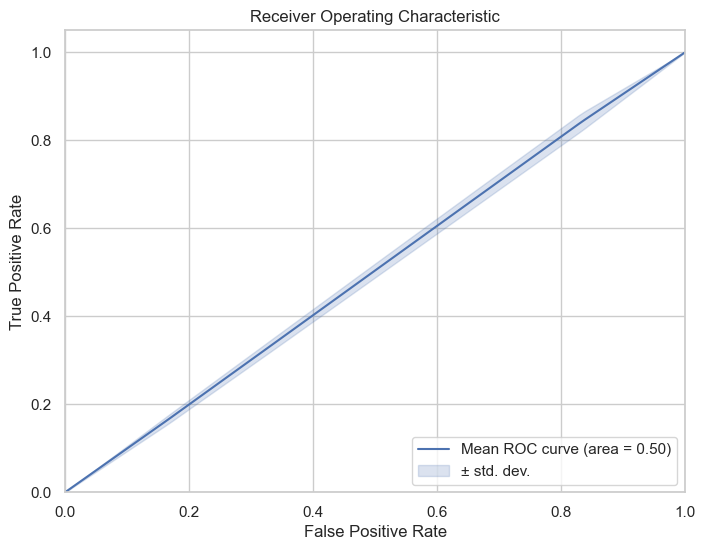

In [64]:
mean_mean_fpr = np.mean(all_mean_fprs, axis=0)
mean_mean_tpr = np.mean(all_mean_tprs, axis=0)
mean_std_tpr = np.mean(all_std_tprs, axis=0)
mean_auc = np.mean(all_aucs)

plot_avg_roc_curve(mean_mean_fpr, mean_mean_tpr, mean_std_tpr, mean_auc)

Permutation t-test

Checking the p-values of each feature to define the importance of each

In [65]:
t_statistics, p_values = svm_classifier.permutation_t_test(X, y, 1000)
# p_values = svm_classifier.permutation_importance(X, y, 1000)

In [66]:
t_stats = {}
p_vals = []

for feat, p_val in p_values:
    lab = total_labels[int(feat[-3:])]
    # lab = feat
    t_stats[lab] = t_statistics[feat]
    p_vals.append((lab,p_val))

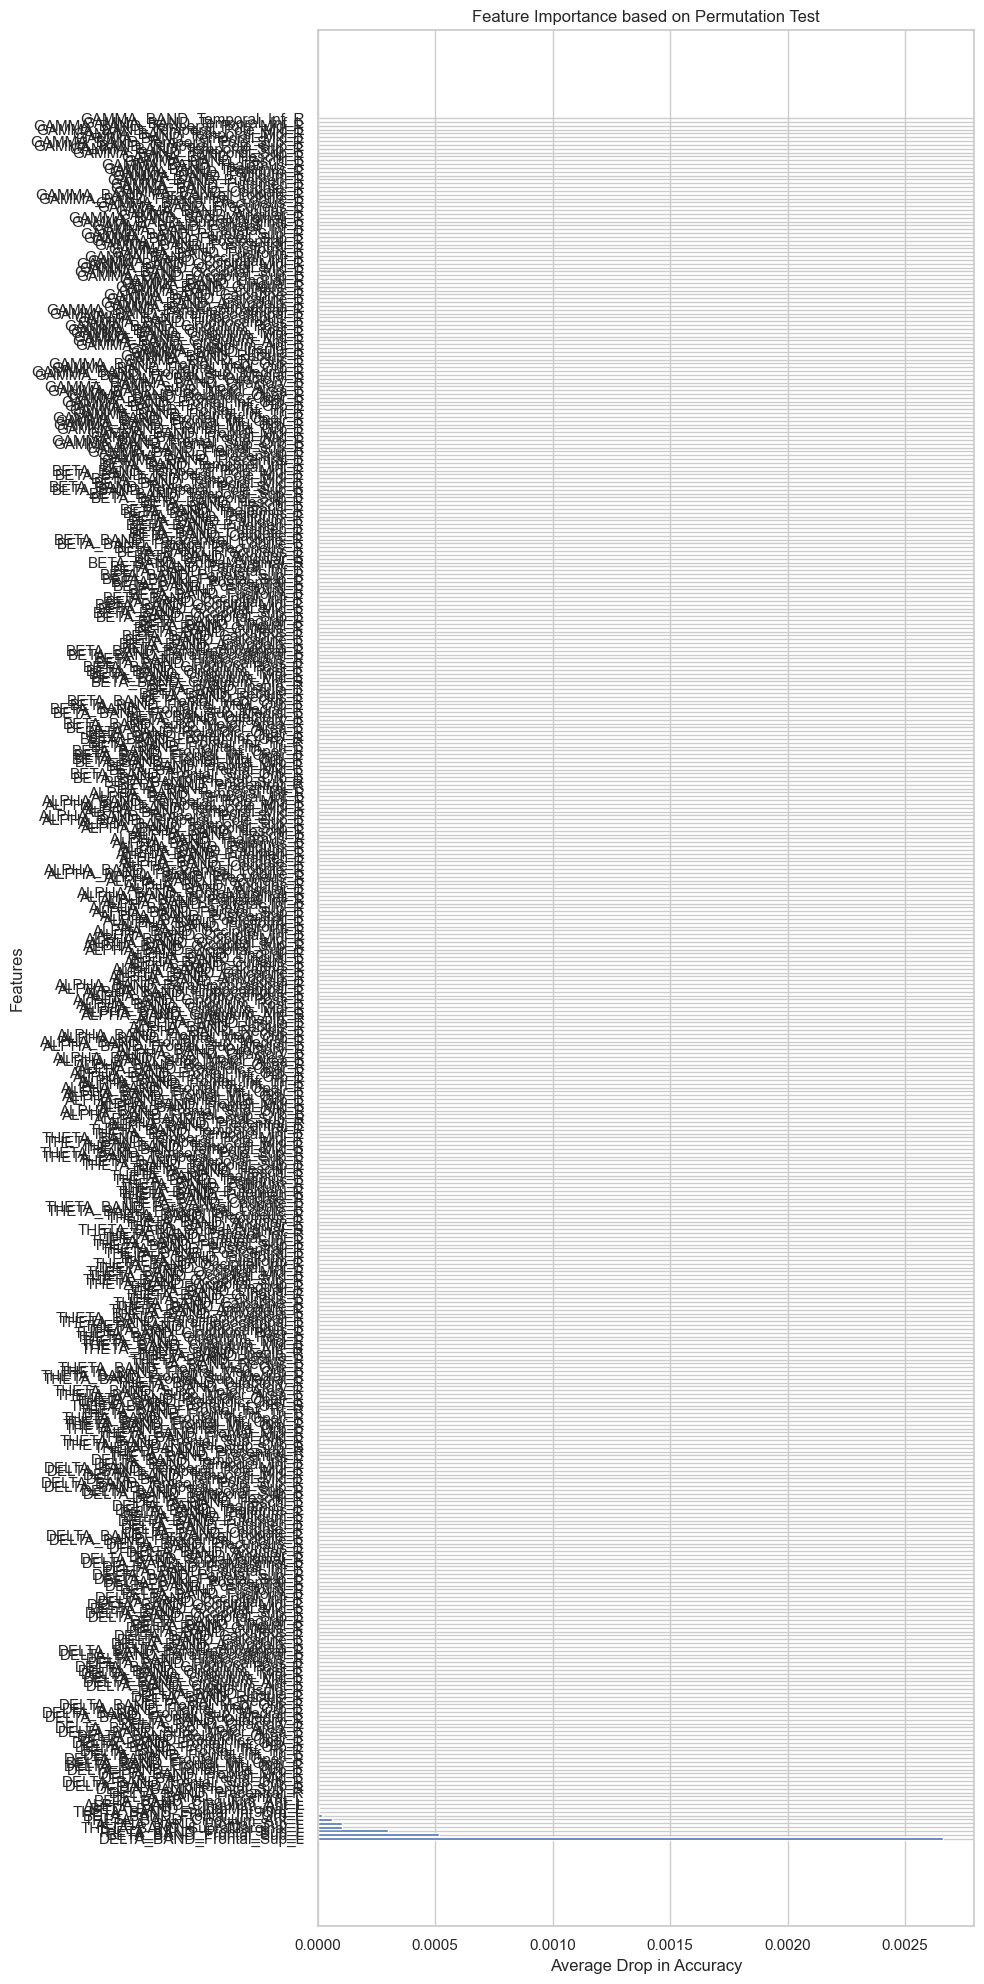

DELTA_BAND_Frontal_Sup_L	p-value: 0.002659933371362157	t-statistic: 3.0120846410688316
BETA_BAND_Frontal_Sup_L	p-value: 0.0005166806029139717	t-statistic: 3.4833322033454994
THETA_BAND_Frontal_Sup_L	p-value: 0.00030076555592796174	t-statistic: 3.6274033014324996
THETA_BAND_SupraMarginal_L	p-value: 0.00010245172631616552	t-statistic: 3.9004099745462524
ALPHA_BAND_Frontal_Sup_L	p-value: 0.00010245172631616552	t-statistic: 3.9004099745462524
THETA_BAND_Cingulum_Ant_L	p-value: 5.9919261599364004e-05	t-statistic: 4.030372493829933
BETA_BAND_Frontal_Inf_Orb_L	p-value: 2.0559598825968332e-05	t-statistic: 4.27920658081607
THETA_BAND_Frontal_Inf_Orb_L	p-value: 4.15533706730607e-06	t-statistic: 4.629147782589099
BETA_BAND_SupraMarginal_L	p-value: 4.15533706730607e-06	t-statistic: 4.629147782589099
ALPHA_BAND_Cingulum_Ant_L	p-value: 2.9160970068560003e-07	t-statistic: 5.16404406733438
BETA_BAND_Cingulum_Ant_L	p-value: 2.4556901404333546e-09	t-statistic: 6.019398692706269
DELTA_BAND_Precentral_L	p

In [67]:
plt.figure(figsize=(10, 20))
plt.barh([x[0] for x in p_vals], [x[1] for x in p_vals])
plt.ylabel('Features')
plt.xlabel('Average Drop in Accuracy')
plt.title('Feature Importance based on Permutation Test')
plt.tight_layout()
plt.show()

for feature, p_val in p_vals:
    print(f"{feature}\tp-value: {p_val}\tt-statistic: {t_stats[feature]}")
    # print(f"{feature}\tp-value: {p_val:.4f}")
